In [ ]:
import numpy as np
from scipy.stats import norm
import scipy.signal as signal
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

nT = 30 # Temporal filter length
nX = 40 # Spatial filter length

N = 30 # Number of neurons

temp_filt = np.zeros((N, nT))
spat_filt = np.zeros((N, nX))

# Define filters manually
for i in range(N-15):
    temp_filt[i,:] = norm.pdf(np.linspace(-15,15,nT), loc=i-12.5+i/1.5, scale=.8)
    spat_filt[i,:] = norm.pdf(np.linspace(-10,10,nX), i-7.5, scale=.8) - .8 * norm.pdf(np.linspace(-10,10,nX), i-7.5, 1)

for i in range(N-15, N):
    temp_filt[i,:] = norm.pdf(np.linspace(-5,5,nT), loc=.45*i-10, scale=.8) - .6*norm.pdf(np.linspace(-5,5,nT), loc=.45*i-9, scale=.8)
    spat_filt[i,:] = norm.pdf(np.linspace(-15,15,nX), loc=1.5*i-33, scale=.7) - .5*norm.pdf(np.linspace(-15,15,nX), loc=1.5*i-33, scale=1.5)

In [5]:
bias = -3 - 2*np.random.uniform(size=N) # Bias
print(bias)
np.save('bias.npy', bias)

[-4.8233723  -4.14269377 -4.51815201 -3.47441995 -4.66578238 -3.71753567
 -3.12595001 -3.28420456 -3.3045512  -4.39743834 -3.70704469 -3.53435163
 -3.3220673  -4.79141047 -3.51321504 -3.32130002 -4.87074709 -3.05215136
 -4.29702337 -4.43342038 -4.22798676 -3.0188797  -3.2914051  -3.70674394
 -3.5801392  -4.51066907 -3.02666987 -4.18836476 -3.98817461 -4.80931264]


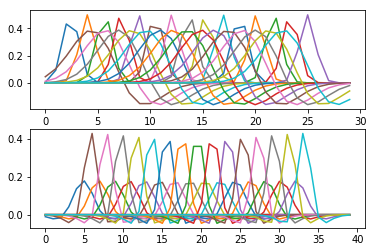

In [6]:
fig, ax =  plt.subplots(2, 1)
for filt in temp_filt:
    ax[0].plot(filt)

for filt in spat_filt:
    ax[1].plot(filt)

plt.show()

In [8]:
W = np.zeros((N, nT, nX))

for i, filts in enumerate(zip(temp_filt, spat_filt)):
    a, b = filts
    f = np.matmul(a[:,np.newaxis], b[np.newaxis,:])
    f = 3 * f/np.linalg.norm(f.flatten())
    W[i,:,:] = f
print(W.shape)
np.save('W.npy', W)

(30, 30, 40)


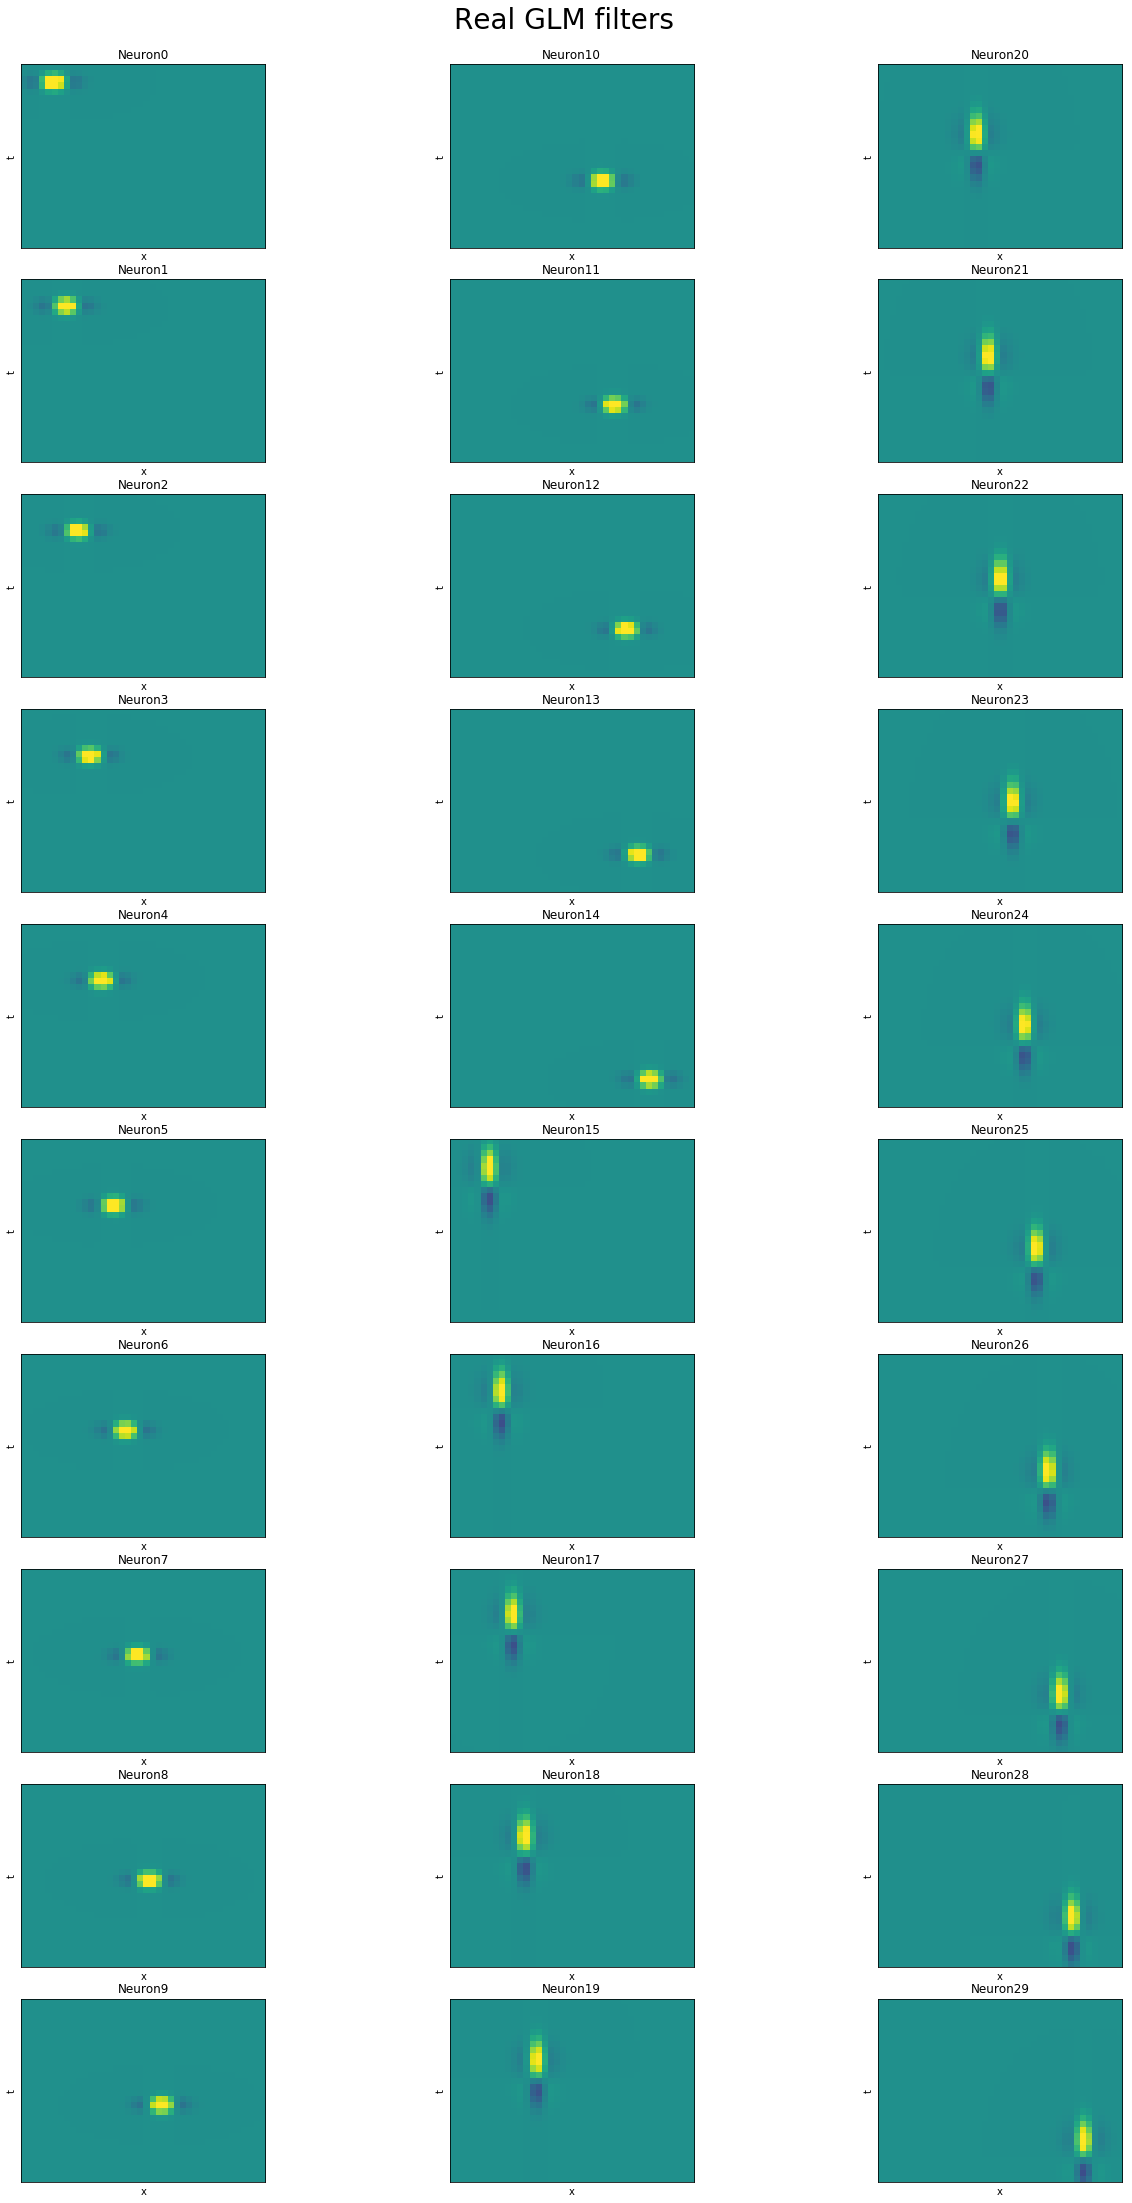

In [9]:
nrow = 10
fig, ax =  plt.subplots(nrow, int(N/nrow), figsize=(18,30))
fig.suptitle('Real GLM filters', fontsize=28, y=1.02)
fig.tight_layout()
for i, f in enumerate(W):
    mapable = ax[i%nrow,int(i/nrow)].imshow(f, vmin=-1, vmax=1)
    ax[i%nrow,int(i/nrow)].set_xlabel('x')
    ax[i%nrow,int(i/nrow)].set_ylabel('t')
    ax[i%nrow,int(i/nrow)].set_xticks([]) 
    ax[i%nrow,int(i/nrow)].set_yticks([])
    ax[i%nrow,int(i/nrow)].set_title('Neuron'+ str(i))
plt.show()

In [10]:
# Stimulation
nBin = 15000
nTrial = 200
stim = np.random.uniform(-1, 1, size=(nBin,nX))
print(stim.shape)

(15000, 40)


In [ ]:
fr = np.zeros((N, nBin))
data = np.zeros((nTrial, nBin, N))
fr_all = np.zeros((nTrial, nBin, N))

for j in range(nTrial):
    shared_noise = np.random.randn(nBin, 1)* .5
    for i, filt in enumerate(W):
        act = signal.convolve2d(stim, filt, mode='valid')
        act = np.concatenate((np.zeros((29,1)), act))
#         print(act.shape, bias.shape, shared_noise.shape)
        pr =  sigmoid(act + bias[i] + shared_noise).flatten()
        fr[i,:] = pr
    fr_all[j, :, :] = fr.transpose()
    data[j, :, :] = np.random.binomial(n=1, p=fr.transpose(), size=(nBin, N))
    
print(data.shape)

In [ ]:
fig, ax = plt.subplots(N,1, figsize=(20, 40))
for i, pr in enumerate(fr):
    ax[i].plot(pr[1000:1500])
    ax[i].set_ylim(0,1)
plt.show()

In [ ]:
fig, ax = plt.subplots(N,1, figsize=(20, 40))
for i, pr in enumerate(fr_all.transpose(2,0,1)):
    for j in range(20):
        ax[i].plot(pr[j, 1000:1500])
        ax[i].set_ylim(0,1)
plt.show()

In [ ]:
for i, spikes in enumerate(data.transpose(2,0,1)):
    fig, ax = plt.subplots(1, 2, figsize=(25, 3))
    ax[0].imshow(spikes[:,0:1000])
    ax[0].set_xlabel('time')
    ax[0].set_ylabel('repetitions')
    ax[0].set_xticks([]) 
    ax[0].set_yticks([])
    ax[0].set_title('Neuron '+str(i))
    
    ax[1].plot(spikes.mean(axis=0)[0:1000], label='spike average')
    ax[1].plot(fr_all[:, 0:1000, i].mean(axis=0), label='Probability', linewidth=.8)
    ax[1].set_xlabel('time')
    ax[1].set_ylim(0,1)
    plt.legend()
    plt.show()

In [ ]:
stim = stim[:,:,np.newaxis]
print(stim.shape)

In [ ]:
np.save('data.npy', data)
np.save('stim.npy', stim)

In [32]:
data.mean(axis=(0,1))

array([0.05758567, 0.05292933, 0.03907933, 0.11012567, 0.05358467,
       0.05474   , 0.06869367, 0.02681367, 0.038003  , 0.03988967,
       0.0699    , 0.09652467, 0.055376  , 0.070026  , 0.065973  ,
       0.11632933, 0.062161  , 0.038409  , 0.09620967, 0.08121067,
       0.02571733, 0.10813967, 0.02613267, 0.02839733, 0.09599267,
       0.08250267, 0.04480033, 0.02658667, 0.07895867, 0.08699167])